# 🔥 Training ResNet-50 on Mixed Real/Synthetic Fire Images

This notebook trains a ResNet-50 classification model using a mixed dataset composed of real images from the D-Fire dataset and synthetic images from the Yunnan UE5-based fire dataset. The goal is to evaluate the effect of different synthetic-to-real ratios on classification performance when tested on real-world data.

We use the new `FireClassificationMixedDataset` helper class to construct the mixed dataset dynamically based on the specified synthetic ratio (e.g., 25%, 50%, 75%). All synthetic images are used (N = 3,946), and the real image count is calculated accordingly to match the desired ratio.

The model is trained using the same training loop defined in `train_model.py`, with evaluation planned on the fixed D-Fire test set using `evaluate_models.ipynb`.




## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [14]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 92 (delta 41), reused 64 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 3.33 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/fire-detection-dissertation


## 🧮 Step 1: Define Synthetic Ratio, Paths, and Model Naming

In this step, we configure the training run by selecting the desired synthetic-to-real ratio. We also set the dataset paths, output model name, and ensure reproducibility via random seed. All synthetic images are included; the number of real images is calculated to match the target ratio.


In [15]:
import os
import random
import torch
import numpy as np

# 🔁 Adjustable: synthetic ratio for current training run
syn_ratio = 0.25  # Change to 0.5 or 0.75 for other runs
total_samples = 5260  # Fixed total training volume for all mixed models


# ✅ Paths to real and synthetic data
real_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/images"
real_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/labels"
syn_image_dir  = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images"
syn_label_dir  = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels"

# 🏷️ Generate model filename dynamically based on ratio
syn_pct = int(syn_ratio * 100)
real_pct = 100 - syn_pct
model_filename = f"resnet_mixed_{syn_pct}syn_{real_pct}real.pt"


# 🎲 Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


## 🖼️ Step 2: Load and Inspect the Mixed Dataset

In this step, we initialise the `FireClassificationMixedDataset` class, which dynamically combines synthetic and real images according to the selected `syn_ratio`.

- All 3,946 synthetic images are included.
- A subset of real images is sampled based on the `syn_ratio`.
- Label mapping is automatically handled:
  - Real: class 1 = fire → label = 1
  - Synthetic: class 0 = fire → label = 1

We also visualise 5 random samples from the mixed dataset to confirm label correctness and image quality.


🧾 Sample counts → Real: 3945, Synthetic: 1315
✅ Total samples in mixed dataset: 5260 (Synthetic: 25%, Real: 75%)


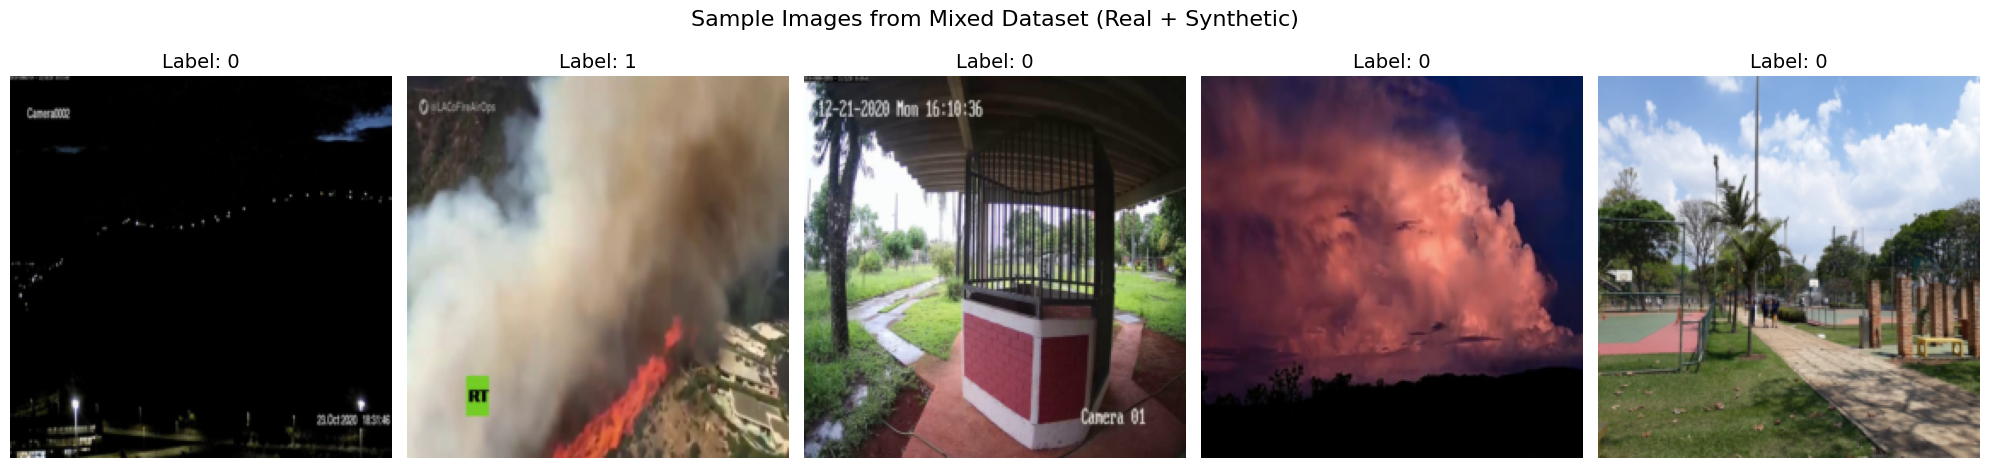

In [16]:
import matplotlib.pyplot as plt
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationMixedDataset

# Define total samples
total_samples = 5260

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Initialise the mixed dataset with the selected syn_ratio
mixed_dataset = FireClassificationMixedDataset(
    real_image_dir=real_image_dir,
    real_label_dir=real_label_dir,
    syn_image_dir=syn_image_dir,
    syn_label_dir=syn_label_dir,
    syn_ratio=syn_ratio,
    total_samples=total_samples,
    transform=transform
)

# Print the proportions of both synthetic and real counts
print(f"🧾 Sample counts → Real: {len(mixed_dataset.sampled_real_images)}, Synthetic: {len(mixed_dataset.sampled_syn_images)}")

# Print dataset size
print(f"✅ Total samples in mixed dataset: {len(mixed_dataset)} (Synthetic: {int(syn_ratio*100)}%, Real: {100 - int(syn_ratio*100)}%)")

# Visualise 5 random samples
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    idx = random.randint(0, len(mixed_dataset) - 1)
    image, label = mixed_dataset[idx]
    axs[i].imshow(image.permute(1, 2, 0))  # Convert CHW → HWC for display
    axs[i].set_title(f"Label: {int(label)}", fontsize=14)
    axs[i].axis("off")

plt.suptitle("Sample Images from Mixed Dataset (Real + Synthetic)", fontsize=16)
plt.tight_layout()
plt.show()


## 🧠 Step 3: Create Train/Validation Split and Load ResNet-50

In this step, we split the combined mixed dataset into a training and validation set (80/20 split). These are then wrapped in PyTorch `DataLoader` objects for batching and shuffling.

We also load a pretrained ResNet-50 model from `torchvision.models`, remove its original classification head, and replace it with a binary output layer (`nn.Linear(2048, 2)`).

This prepares the model to perform fire/no-fire classification using transfer learning.


In [17]:
import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import random_split, DataLoader

# 🖥️ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# 📊 Split the dataset (80% train, 20% val) with fixed seed for reproducibility
train_size = int(0.8 * len(mixed_dataset))
val_size = len(mixed_dataset) - train_size

generator = torch.Generator().manual_seed(42)  # ensures consistent split
train_dataset, val_dataset = random_split(mixed_dataset, [train_size, val_size], generator=generator)

print(f"📊 Dataset split → Train: {train_size}, Validation: {val_size}")

# 📦 Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 🧠 Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# ❄️ Feature extraction mode: freeze all layers
for param in model.parameters():
    param.requires_grad = False

# ✂️ Replace final FC layer with binary classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # fire / no fire

# 🚀 Move to GPU if available
model = model.to(device)

# 🎯 Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# 🗃️ Training configuration
num_epochs = 5
save_path = f"/content/drive/MyDrive/fire-detection-dissertation/models/{model_filename}"

print("✅ Model, DataLoaders, and training configuration are ready.")


🖥️ Using device: cuda
📊 Dataset split → Train: 4208, Validation: 1052


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model, DataLoaders, and training configuration are ready.


## 🔁 Step 4: Train the Model on Mixed Dataset

In this step, we fine-tune the final classification layer of a pretrained ResNet-50 using the mixed dataset. All convolutional layers are frozen, so only the new fully connected layer is updated.

We use the `train_model()` helper function from `utils/train_model.py`, which handles:
- Epoch-wise training and validation loss tracking
- GPU support
- Model saving
- Optional per-batch logging

Training is performed for 5 epochs to match previous experiments.


In [18]:
from utils.train_model import train_model

# Run training loop using helper function
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,  # currently set to 5 above
    device=device,
    save_path=save_path,
    print_every=1,           # print epoch summary each time
    print_batch_loss=False   # optional: set True to debug batch losses
)



🔍 Model device: cuda:0

🔁 Epoch 1/5


✅ Epoch [1/5] | Train Loss: 0.5292 | Val Loss: 0.4260 | Acc: 0.8460 | Precision: 0.8605 | Recall: 0.7551 | F1: 0.8043 | Time: 1446.4s
💾 New best model saved (F1: 0.8043) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_mixed_25syn_75real.pt

🔁 Epoch 2/5


✅ Epoch [2/5] | Train Loss: 0.3986 | Val Loss: 0.3593 | Acc: 0.8707 | Precision: 0.8352 | Recall: 0.8617 | F1: 0.8482 | Time: 69.5s
💾 New best model saved (F1: 0.8482) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_mixed_25syn_75real.pt

🔁 Epoch 3/5


✅ Epoch [3/5] | Train Loss: 0.3520 | Val Loss: 0.3283 | Acc: 0.8774 | Precision: 0.8348 | Recall: 0.8821 | F1: 0.8578 | Time: 70.7s
💾 New best model saved (F1: 0.8578) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_mixed_25syn_75real.pt

🔁 Epoch 4/5


✅ Epoch [4/5] | Train Loss: 0.3266 | Val Loss: 0.3006 | Acc: 0.8992 | Precision: 0.9056 | Recall: 0.8481 | F1: 0.8759 | Time: 70.9s
💾 New best model saved (F1: 0.8759) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_mixed_25syn_75real.pt

🔁 Epoch 5/5


✅ Epoch [5/5] | Train Loss: 0.3099 | Val Loss: 0.2920 | Acc: 0.9049 | Precision: 0.9338 | Recall: 0.8322 | F1: 0.8801 | Time: 70.0s
💾 New best model saved (F1: 0.8801) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_mixed_25syn_75real.pt


In [11]:
# ✅ 1. Navigate to the Git-tracked repo folder
%cd /content/fire-detection-dissertation

# ✅ 2. Move the notebook from Drive into the repo so Git can track it
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/05_train_resnet_mixed_ratios.ipynb /content/fire-detection-dissertation/notebooks/

# Optional: confirm it's now inside the repo
!ls notebooks/

# ✅ 3. Stage the notebook for commit
!git add notebooks/05_train_resnet_mixed_ratios.ipynb

# ✅ 4. Commit with a message
!git commit -m "Added training notebook for mixed real/synthetic dataset ratios (25/50/75)"

# ✅ 5. Push to GitHub
!git push


/content/fire-detection-dissertation
01_setup_environment.ipynb	 04_train_resnet_synthetic_only.ipynb
02_data_preprocessing.ipynb	 05_train_resnet_mixed_ratios.ipynb
03_train_resnet_real_only.ipynb  evaluate_models.ipynb
[main b1ae6a3] Added training notebook for mixed real/synthetic dataset ratios (25/50/75)
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/05_train_resnet_mixed_ratios.ipynb (87%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 761.00 KiB | 13.12 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   b77ebcf..b1ae6a3  main -> main
